---
title: Are you in the top 1% of brawl stars players?
author: Dominik Moser, Ole Petersen
format: 
  html: default
  ipynb: default
  typst: default
  md: default
abstract: We simulate brawl stars 3v3 to find out how good a certain amount of trophies is compared to the other players. Our results from a billion games show that you need around 920 trophies on a brawler to be in the top 1% of players. The main input to the simulation is the trophy update rule, which is publicly available. We also find that the percentile of players with a certain amount of trophies is surprisingly independent from other parameters such as the number of players or the effect of the player's skill on the outcome of the game.
---

Have you ever wondered how good you are at the game [Brawl Stars](https://supercell.com/en/games/brawlstars/)? Are you in the top 1% of players? In this post, we will find out by simulating the game with a million players using [Julia](https://julialang.org/).

## Our model

Brawl stars is a multiplayer game. We will analyze the `3v3` game mode where two teams of three players each fight against each other. We are primarily interested in top players; therefore, we will assume that all brawlers are maxed out. The strength of a player is assumed to be soley determined by a single number, the skill level, which is constant over all games. Players have a trophy count for the brawler they play, which is changing over the rounds. We assume players are matched based on the trophy count of the brawler they play.

We simplistically assume that the game is played in discrete global rounds. For each round, each player joins with a probability of `activity_level`, which is individual for each player. If a player has an activity level of $1$, they play in every round.

This leaves us with the following model:

In [47]:
#| echo: true
#| output: false
using Distributions
using Random

mutable struct Player
    trophies::Int
    skill::Float64
    activity::Float64
    streak::Int
    Player(skill_dist=Normal(0, 3),activity_dist=Uniform(0.2, 1)) = new(0, rand(skill_dist), rand(activity_dist),0)
end

Here, we assume that the skill level of the players is distributed as $\mathcal{N}(\mu=0,\sigma=3)$ and the activity level is distributed as $\mathcal{U}(0.2,1)$.

Consequently, the players that are active in a round are drawn as follows:

In [48]:
#| echo: true
#| output: false
function sample_players_in_round(players::Vector{Player})
    mask = [rand(Bernoulli(p.activity)) for p in players]
    return players[mask]
end

sample_players_in_round (generic function with 1 method)

Now, let us consider the outcome of a game. We assume that the strength of a team is the average skill of its players. If two teams with average skills $m_1$ and $m_2$ play against each other, we model the probability of team 1 winning as
$$
P(\text{team 1 wins}) = \frac{1}{1 + \exp(m_2 - m_1)}.
$$
This is implemented as follows:

In [49]:
#| echo: true
#| output: false
function play(g1::AbstractVector{Player}, g2::AbstractVector{Player})
    m1 = mean([p.skill for p in g1])
    m2 = mean([p.skill for p in g2])
    p_team_1_wins = 1 / (1 + exp(m2 - m1))
    return rand(Bernoulli(p_team_1_wins))
end

play (generic function with 1 method)

How are the players rewarded or penalized after a game? This data is publicly accesible [here](https://brawlstars.fandom.com/wiki/Trophies) and can be verified within the game.

In [54]:
#| echo: true
#| output: true
using MarkdownTables
trophy_changes = DataFrame(
    "min trophies" => [0, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200],
    "max trophies" => [49, 99, 199, 299, 399, 499, 599, 699, 799, 899, 999, 1099, 1199, Inf],
    "win trophy bonus" => [8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 6, 5, 4, 3],
    "loss trophy penalty" => [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -12]
)
@assert trophy_changes == trophy_changes_2
markdown_table(trophy_changes)

| min trophies | max trophies | win trophy bonus | loss trophy penalty |
|--------------|--------------|------------------|---------------------|
|            0 |         49.0 |                8 |                   0 |
|           50 |         99.0 |                8 |                  -1 |
|          100 |        199.0 |                8 |                  -2 |
|          200 |        299.0 |                8 |                  -3 |
|          300 |        399.0 |                8 |                  -4 |
|          400 |        499.0 |                8 |                  -5 |
|          500 |        599.0 |                8 |                  -6 |
|          600 |        699.0 |                8 |                  -7 |
|          700 |        799.0 |                8 |                  -8 |
|          800 |        899.0 |                7 |                  -9 |
|          900 |        999.0 |                6 |                 -10 |
|         1000 |       1099.0 |                5 |                 -11 |
|         1100 |       1199.0 |                4 |                 -12 |
|         1200 |          Inf |                3 |                 -12 |


So now, let us write a function that returns the new trophy count of the players after a game. Since this is run billions of times, we pre-compute the result in bins of 50 trophies.

Further, there is a concept called _win streaks_. If a player wins 2 games in a row, they get one extra trophy, for 3 wins in a row, they get 2 extra trophies, up to 5 extra posts for 6 wins in a row. Let us implement this:

In [36]:
num_bins = 1200 ÷ 50 + 1
to_bin(trophies::Int) = 1 + min(trophies, 1200) ÷ 50
win_trophies_by_bin = zeros(Int, num_bins)
loss_trophies_by_bin = zeros(Int, num_bins)
for trophy in 0:50:1200
    df_row = first(filter(row -> row[1] <= trophy <= row[2], eachrow(trophy_changes)))
    win_trophies_by_bin[to_bin(trophy)] = df_row["win trophy bonus"]
    loss_trophies_by_bin[to_bin(trophy)] = df_row["loss trophy penalty"]
end
function get_trophy_change(trophies::Int, win::Bool, streak_length::Int=0)
    trophy_bin = to_bin(trophies)
    return clamp(streak_length - 1, 0, 5) + (win ? win_trophies_by_bin[trophy_bin] : loss_trophies_by_bin[trophy_bin])
end
@assert all(get_trophy_change.(trophy_changes[:, "min trophies"], true) .== trophy_changes[:, "win trophy bonus"])
@assert all(get_trophy_change.(trophy_changes[:, "min trophies"], false) .== trophy_changes[:, "loss trophy penalty"])
println("Trophy change at 543 trophies after a win: ", get_trophy_change(543, true))
println("Trophy change at 543 trophies after a loss: ", get_trophy_change(543, false))

Trophy change at 543 trophies after a win: 8
Trophy change at 543 trophies after a loss: -6


This code may seem complicated due to the precomputation. A more simple version would be:

```julia
min_trophies = trophy_changes[:,"min trophies"]
max_trophies = trophy_changes[:,"max trophies"]
win_trophy_bonus = trophy_changes[:,"win trophy bonus"]
loss_trophy_penalty = trophy_changes[:,"loss trophy penalty"]
function get_trophy_change(trophies::Int, win::Bool, streak_length::Int)
    for i in 1:length(min_trophies)
        if trophies >= min_trophies[i] && trophies <= max_trophies[i]
            if win
                return clamp(streak_length - 1, 0, 5) + win_trophy_bonus[i]
            else
                return clamp(streak_length - 1, 0, 5) + loss_trophy_penalty[i]
            end
        end
    end
end
```

Next, let us implement a round of the game. We first get the active players in this round and sort them by their trophy cound. This allows us to pair the players with similar trophy levels: We split the list of active players in chunks of size `6=2*team_size`. Since the list is sorted, each group of 6 has a similar trophy count. We then permute the players in the group randomly and assign the first three to group 1 and the last three to group 2. The trophies of the players are then updated accordingly. Each group is executed in parallel using `Threads.@threads`:

In [37]:
#| echo: true
#| output: false
function step!(players::Vector{Player}, team_size::Int=3)
    players_in_round = sample_players_in_round(players)
    sorted_players = sort(players_in_round, by=p -> p.trophies)
    permutation = randperm(2 * team_size)
    Threads.@threads for i in 1:(2*team_size):(length(sorted_players)-2*team_size)
        @views begin
            shuffled_players = sorted_players[i:i+2*team_size-1][permutation]
            team1 = shuffled_players[1:team_size]
            team2 = shuffled_players[team_size+1:end]
            @assert length(team1) == length(team2) == team_size
            team1_wins = play(team1, team2)
            for p in team1
                p.streak += 1
                p.trophies += get_trophy_change(p.trophies, team1_wins, p.streak)
            end
            for p in team2
                p.streak = 0
                p.trophies += get_trophy_change(p.trophies, !team1_wins,p.streak)
            end
        end
    end
end

step! (generic function with 2 methods)

Now, let us simulate a few rounds of the game:

In [38]:
#| echo: true
#| output: false
num_players = 1000000
num_rounds = 1000
players = [Player() for i in 1:num_players]
for round in 1:num_rounds
    step!(players)
end

First, we would like to find out the correlation between the skill level and the trophy count. @fig-skills-vs-trophies shows the result of a simulation with 1 million players. It is visible that a higher skill level is clearly correlated with a higher trophy count.

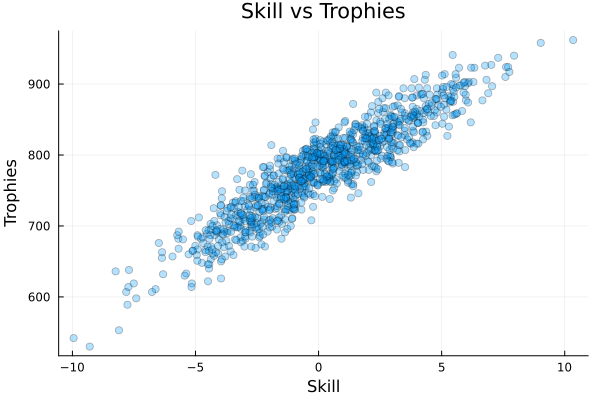

In [39]:
#| echo: true
#| label: fig-skills-vs-trophies
#| fig-cap: Skill level vs trophies for the first 1000 players
using Plots
players_to_plot = players[1:1000]
scatter([p.skill for p in players_to_plot], [p.trophies for p in players_to_plot], label="Skill vs Trophies", xlabel="Skill", ylabel="Trophies", title="Skill vs Trophies",alpha=0.3, legend=false)

Next, let us find out what we are interested in: the top 1% of players. To do so, we sort the players by their trophy count and plot how many players have more than a certain number of trophies in @fig-trophies-cdf.

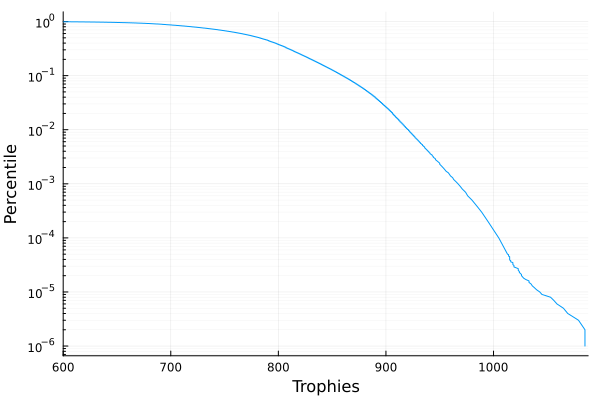

In [40]:
#| echo: true
#| label: fig-trophies-cdf
#| fig-cap: Fraction of players with at least a certain number of trophies
trophies=[p.trophies for p in players]
trophies=sort(trophies)
percent_better=1.0 .- (1:num_players) ./num_players
# plot all but the last 50 in steps of 100 and the last 50 players
to_plot=vcat(1:100:(num_players-50),(num_players-50):(num_players-1))
plot(trophies[to_plot], percent_better[to_plot], label="Trophies", xlabel="Trophies", ylabel="Percentile", yscale=:log10, xlims=(600,maximum(trophies)),yminorgrid=true, legend=false)

In the following table you can see that you need around 920 trophies to be in the top 1% of players:

In [41]:
percentiles_to_list=[10,5,2,1,0.1,0.01,0.001]
indices=[ceil(Int,(1-percentile/100)*num_players) for percentile in percentiles_to_list]
trophies_at_percentiles=trophies[indices]
df=DataFrame("Percentile (%)"=>percentiles_to_list,"Trophies"=>trophies_at_percentiles)
markdown_table(df)

| Percentile (%) | Trophies |
|----------------|----------|
|           10.0 |      860 |
|            5.0 |      883 |
|            2.0 |      906 |
|            1.0 |      921 |
|            0.1 |      967 |
|           0.01 |     1004 |
|          0.001 |     1043 |


Next, let us test how this curve depends on the number of players. @fig-trophies-cdf-players shows an interesting result: If there are more players in the game, it is easier to be in the top few players of the game. For the bulk of the players, the number of players does not really matter for the relative position. Based on [this](https://activeplayer.io/brawl-stars/), brawl stars has around a million daily active players, so the initial plot is the most relevant.

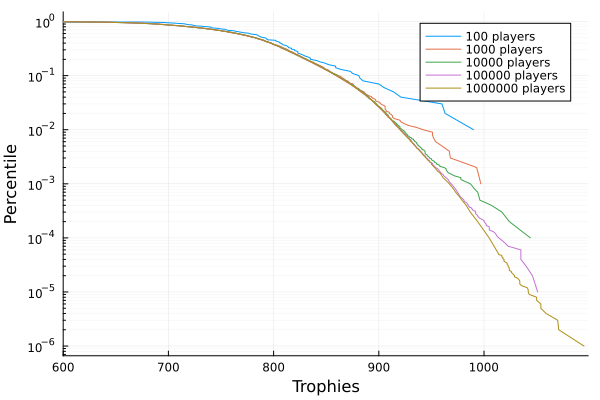

In [42]:
#| echo: true
#| fig-format: png
#| label: fig-trophies-cdf-players
#| fig-cap: Fraction of players with at least a certain number of trophies for different numbers of players and a skill standard deviation of 3 after 1000 rounds
p=plot(xlabel="Trophies", ylabel="Percentile", yscale=:log10, yminorgrid=true)
num_rounds=1000
for num_players in [100,1000, 10000, 100000, 1000000]
    players = [Player() for i in 1:num_players]
    for round in 1:num_rounds
        step!(players)
    end
    trophies=[p.trophies for p in players]
    trophies=sort(trophies)
    percent_better=1.0 .- (1:num_players) ./num_players
    num_points_to_plot=10000
    step=ceil(Int,num_players/num_points_to_plot)
    # plot all but the last 50 in steps of step and the last 50 players
    to_plot=vcat(1:step:(num_players-50),(num_players-50):(num_players-1))
    plot!(p,trophies[to_plot], percent_better[to_plot], label="$num_players players", xlims=(600,maximum(trophies)))
end
display(p)

Next, let us find out how the curve depends on the standard deviations of the skill level. This model parameter is crucial since the formula for the probability of winning a game depends on the average skill level of the team members:
$$
P(\text{team 1 wins}) = \frac{1}{1 + \exp(m_2 - m_1)}.
$$
The standard deviation controls how likely the best players win against the worst players. Let us see how likely the top 5% of players win against the bottom 5% of players for different standard deviations, as depicted in @fig-win-probability-top-vs-bottom.

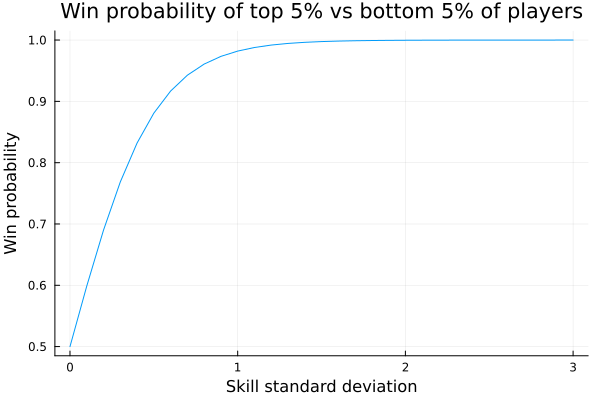

In [43]:
#| echo: true
#| label: fig-win-probability-top-vs-bottom
#| fig-cap: Win probability of the top player 5% of players vs the bottom 5% of players for different skill standard deviations

# The top 5% of players have a skill of 2 standard deviations above the mean, while the bottom 5% have a skill of 2 standard deviations below the mean
p_win(std) = 1 / (1 + exp(-2*std+(-2*std)))
stds=0:0.1:3
plot(stds, p_win.(stds), label="Win probability of top 5% vs bottom 5%", xlabel="Skill standard deviation", ylabel="Win probability", title="Win probability of top 5% vs bottom 5% of players", legend=false)

Running the simulation with different standard deviations shows that its influence is surprisingly minimal, as shown in @fig-trophies-cdf-variance. The curves are almost identical except for very high trophy counts. This means our result is robust against changes in this somehow arbitrary parameter.

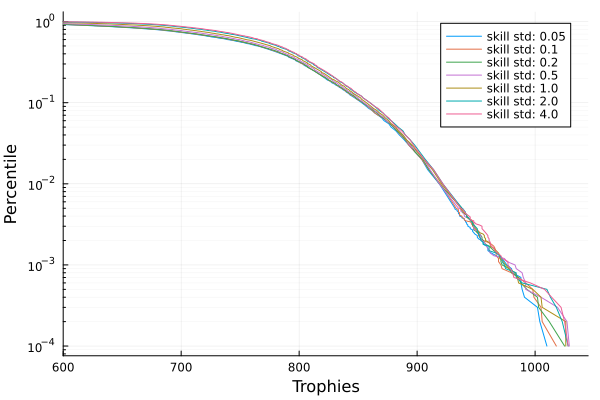

In [44]:
#| echo: true
#| label: fig-trophies-cdf-variance
#| fig-cap: Fraction of players with at least a certain number of trophies for different skill standard deviations and 10000 players after 1000 rounds.
p=plot(xlabel="Trophies", ylabel="Percentile", yscale=:log10, yminorgrid=true)
num_players=10000
num_rounds=1000
for std in [0.05, 0.1, 0.2, 0.5, 1, 2,4]
    players = [Player(Normal(0,std)) for i in 1:num_players]
    for round in 1:num_rounds
        step!(players)
    end
    trophies=[p.trophies for p in players]
    trophies=sort(trophies)
    percent_better=1.0 .- (1:num_players) ./num_players
    # plot all but the last 50 in steps of 50 and the last 50 players
    to_plot=vcat(1:50:(num_players-50),(num_players-50):(num_players-1))
    plot!(p,trophies[to_plot], percent_better[to_plot], label="skill std: $std", xlims=(600,maximum(trophies)))
end
display(p)

Finally, we find in @fig-active-vs-trophies that playing more actively does not influence the trophy count significantly.

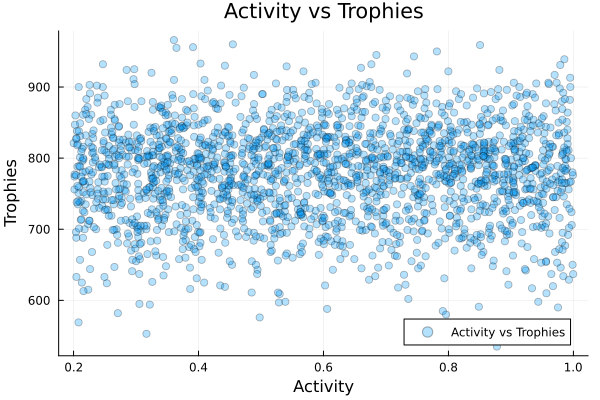

In [45]:
#| echo: true
#| label: fig-active-vs-trophies
#| fig-cap: Activity level vs trophies for the first 20000 players
players_to_plot = players[1:2000]
scatter([p.activity for p in players_to_plot], [p.trophies for p in players_to_plot], label="Activity vs Trophies", xlabel="Activity", ylabel="Trophies", title="Activity vs Trophies", alpha=0.3)

To conclude, we found that you need 864 trophies to be in the top 1% of players in Brawl Stars. This result is robust against changes in the standard deviation of the skill level and the activity level of the players. We hope you enjoyed this post and learned something new about Brawl Stars! And remember, it is just a game; playing too much does not help in our simulation.

As a bonus, we animated the trophy count of the players over the games:

{{< video skill_vs_trophies.mp4 >}}

In [46]:
#| echo: true
#| output: false
using Plots
num_players = 10000
num_rounds = 2000
players = [Player() for i in 1:num_players]
every=10
global lower_bound=0.0
global upper_bound=500.0
a=@animate for round in 1:every:num_rounds
    for i in 1:every
        step!(players)
    end
    players_to_plot = players[1:1000]
    min_trophies=minimum([p.trophies for p in players_to_plot])
    max_trophies=maximum([p.trophies for p in players_to_plot])
    if round < 1000
        global lower_bound += 0.05*(min_trophies-30-lower_bound)
        global upper_bound += 0.1*(max_trophies+200-upper_bound)
    end
    scatter([p.skill for p in players_to_plot], [p.trophies for p in players_to_plot], xlabel="Skill", ylabel="Trophies", title="Skill vs Trophies (round $round)",alpha=0.3, legend=false, ylims=(lower_bound,upper_bound),yminorgrid=true)
end
gif(a, "skill_vs_trophies.gif", fps = 20)
println("Done rendering")
run(`ffmpeg -f gif -i skill_vs_trophies.gif -y -pix_fmt yuv420p skill_vs_trophies.mp4`)

Done rendering


┌ Info: Saved animation to /Users/ole/Documents/software/blog/trophy_simulation/skill_vs_trophies.gif
└ @ Plots /Users/ole/.julia/packages/Plots/ju9dp/src/animation.jl:156
ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma -

Process(`ffmpeg -f gif -i skill_vs_trophies.gif -y -pix_fmt yuv420p skill_vs_trophies.mp4`, ProcessExited(0))